In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import keras
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Convolution1D, MaxPooling1D, Flatten, BatchNormalization, Dense
from keras import metrics
from keras.activations import relu, sigmoid, softmax
from keras import backend as K
import numpy as np
from keras.models import load_model
import sklearn.metrics as metrics
from visualise_data import plot_confusion_matrix
import h5py

Using TensorFlow backend.


In [3]:

def readHDF(path):

    with h5py.File(path,'r') as hdf:
        Input = hdf.get('Input')
        Output = hdf.get('Output')
        input_items = list(Input.items())
        output_items = list(Output.items())

        x_train = np.array(Input.get('x_train'))
        y_train = np.array(Output.get('y_train'))
        x_test = np.array(Input.get('x_test'))
        y_test = np.array(Output.get('y_test'))

        x_train = np.array(x_train)
        y_train = np.array(y_train)
        x_test = np.array(x_test)
        y_test = np.array(y_test)


        print('x train: ',np.shape(x_train),'y train: ',np.shape(y_train),'x test: ',np.shape(x_test),'y test: ',np.shape(y_test))


    return (x_train, y_train, x_test, y_test)

In [4]:
path = 'D:\ParkHere\Hdf_data\061118_Hdf_data_multi_class.h5'
x_train, y_train, x_test, y_test = readHDF(path)

x train:  (3258, 61, 4) y train:  (3258, 4) x test:  (815, 61, 4) y test:  (815, 4)


In [5]:
from pylab import *
import numpy as np

def plot_data(training_loss, val_loss, epochs):

    plt.figure(figsize=(10, 4))
    x_ax = np.arange(1, len(val_loss)+1,1)
    #import pdb; pdb.set_trace()
    plt.plot(x_ax, val_loss, 'bo', label='Test accuracy')
    plt.plot(x_ax, training_loss, label='Training accuracy')
    plt.legend()
    plt.xlabel('Nr. of epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Performance after '+ str(len(val_loss))+' epochs, '+ 'accuracy: '+ str(val_loss[-1]))
    plt.show()

In [6]:
def get_wrong_pred_data(y_pred_labels, y_true_labels):

    wrong_preds = y_pred_labels-y_true_labels
    wrong_x = []
    wrong_y_preds = []
    y_trues = []
    for wp, x, y_pred, y_true in zip(wrong_preds, x_test, y_pred_labels,y_true_labels):
        if wp != 0:
            wrong_x.append(x)
            wrong_y_preds.append(y_pred)
            y_trues.append(y_true)
    return(wrong_x, wrong_y_preds,y_trues)

In [8]:
def plot_sensor_data(x_data, wrong_y_pred, y_true):
    new_x = []
    for i in x_data:
        if -1 not in i:
            new_x.append(i)
    new_x = np.asarray(new_x)
    print(new_x)
    plt.plot(new_x[:,0], new_x[:,2], 'ro') 
    plt.ylabel('segment[1/3m]')
    plt.xlabel('time')
    plt.title('Time against segment of false prediction')
    plt.suptitle('Prediction: '+str(wrong_y_pred)+' True value: '+str(y_true)+ ('\n0= Car in, 1= Car out, 2= Motorcycle, 3= Pedestrian'), va = 'bottom')
    plt.show()
    

In [7]:
def plot_wrongs():
    
    model = load_model('D:\ParkHere\Keras_models\model_'+'multi_class'+'.h5')
    layer_output = model.predict(x_test, verbose = 0)
    #layer_output = np.round(layer_output)

    #print(np.shape(y_test), y_diff, layer_output[0:100])
    y_true_labels = np.argmax(y_test, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)

    y_pred_labels = np.argmax(layer_output, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)
    confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)  # shape=(12, 12)

    class_names = ('Car_in', 'Car_out', 'Motorcycle', 'Pedestrian')
    plt.figure()
    plot_confusion_matrix(confusion_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')
    
    
    wrong_x, wrong_y_preds,y_trues = get_wrong_pred_data(y_pred_labels, y_true_labels)
    print('Amount of wrong samples: '+ str(len(wrong_x)))
    sample = 0
    x_data = wrong_x[sample]
    y_pred = wrong_y_preds[sample]
    y_true = y_trues[sample]

    plot_sensor_data(x_data, y_pred, y_true)
    



In [10]:
"""
Network for Park Here
~~~~~~~~~~~~
Network for identifying the corresponding car counts for a sequence of values referring to the segment clicked on the
sensor stripe.
"""

class Net(object):


    def __init__(self, batch_size, epochs, optimizer, activation, minDelta, patience ):


        self.batch_size = batch_size
        self.epochs = epochs
        self.optimizer = optimizer
        self.activation = activation
        self.minDelta = minDelta
        self.patience = patience

    ##### Creation of the model
    def createModel(self):
        model = Sequential()

        # for the input shape keras ignores first dimension (batch size)
        model = load_model('D:\ParkHere\Keras_models\061118_model_multi_class.h5')

        
        model.summary()
        return(model)

    ##### Execution/Training of the model
    def exeModel(self, x_train, x_test, y_train, y_test):
        model = self.createModel()
        esCallBack = keras.callbacks.EarlyStopping(min_delta=self.minDelta, patience=self.patience)

        model.compile(loss='binary_crossentropy',
                      optimizer=self.optimizer,metrics=["accuracy"])
        history = model.fit(x_train, y_train,
                            batch_size=self.batch_size,
                            epochs=self.epochs,
                            verbose=0,
                            validation_data=(x_test, y_test), callbacks = [esCallBack])

        model.save('D:\ParkHere\Keras_models\model_'+'multi_class'+'.h5')
        plot_data(history.history['acc'],history.history['val_acc'], self.epochs)
        return('Done')
        #return(history.history['loss'],history.history['val_loss'])


In [9]:
"""
Network for Park Here
~~~~~~~~~~~~
Hyperparameters that are passed to the network.
"""

#### Libraries
import keras
from keras.activations import relu, sigmoid
from keras import optimizers
from keras.optimizers import Adam, SGD


 Activation: sigmoid, Optimizer: <keras.optimizers.Adam object at 0x00000199370EC978>, Batch size: 20 Stops at 50 epochs, if no minimum improvement of: 0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 61, 10)            290       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 30, 10)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 30, 20)            1420      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 15, 20)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 15, 40)            5640      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 7, 40)            

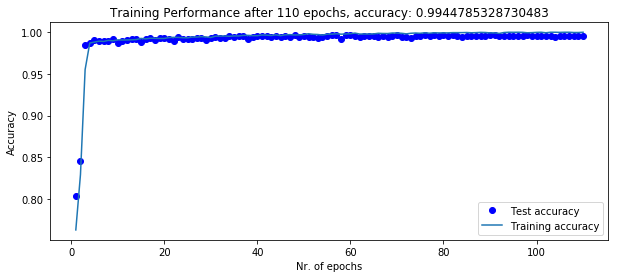

Confusion matrix, without normalization


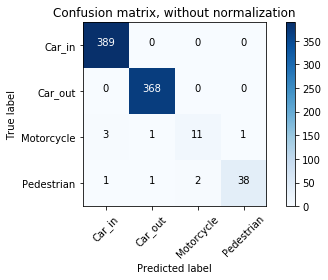

Amount of wrong samples: 9
[[0.         0.         0.         1.        ]
 [0.0018377  0.         0.25       1.        ]
 [0.00445978 0.         0.25       0.        ]
 [0.00493041 0.         0.         0.        ]
 [0.11283925 0.         0.25       1.        ]
 [0.11756796 0.         0.25       0.        ]
 [0.1399117  0.         1.         1.        ]
 [0.14526792 0.         1.         0.        ]
 [0.57179355 1.         1.         1.        ]
 [0.57596199 1.         1.         0.        ]
 [0.85670424 0.         0.75       1.        ]
 [0.8627552  0.         0.75       0.        ]
 [0.98789807 0.         0.5        1.        ]
 [0.98899621 0.         0.75       1.        ]
 [0.99092356 0.         0.         1.        ]
 [0.99459896 0.         0.         0.        ]
 [0.99941731 0.         0.75       0.        ]
 [1.         0.         0.5        0.        ]]


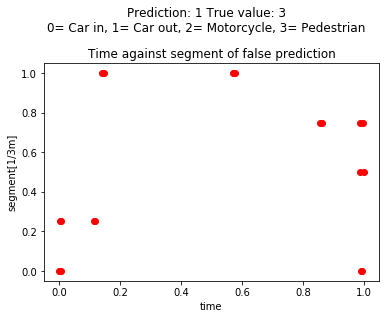

In [11]:
##### Hyperparameters
sgd = optimizers.SGD(lr=0.01)
adam = keras.optimizers.Adam()
batchsize = 20
epochs = 400
optimizer = adam
activation = 'sigmoid'
minDelta = 0
patience = 50

print ( ' Activation: '+activation+ ', Optimizer: '+str(optimizer)+
        ', Batch size: '+ str(batchsize)+' Stops at '+
       str(patience) + ' epochs, if no minimum improvement of: ' + str(minDelta))

Network = Net(batchsize, epochs, optimizer, activation, minDelta, patience)

Network.exeModel(x_train, x_test, y_train, y_test)
plot_wrongs()

In [12]:
def visualise_data(X, Y1, Y2, meta):
    X[10], Y1[10], Y2[10], meta[10]
    
    max_len = max([len(xi) for xi in X])
    print('Maximal sequence length: '+ str(max_len))
    print('Shape of input data: ', str(np.shape(X)))
    print('Histogram of sequence length: ')
    seq_lens = []

    for xi in X:
        seq_lens.append(len(xi))
    matplotlib.pyplot.hist(seq_lens, bins= 30)

In [13]:
visualise_data(X, Y1, Y2, meta)

NameError: name 'X' is not defined